<a href="https://colab.research.google.com/github/Seyed-Ali-Ahmadi/Building-Damage-Assessment/blob/master/03_Dehazing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import cv2

In [2]:
class Node(object):
  def __init__(self, x, y, value):
    self.x = x
    self.y = y
    self.value = value

  def printInfo(self):
    print(self.x, self.y, self.value)

In [23]:
def getMinChannel(img):

	if len(img.shape)==3 and img.shape[2]==3:
		pass
	else:
		print("bad image shape, input must be color image")
		return None

	imgGray = np.zeros((img.shape[0],img.shape[1]),dtype = np.uint8)
	localMin = 255

	for i in range(0,img.shape[0]):
		for j in range(0,img.shape[1]):
			localMin = 255
			for k in range(0,3):
				if img.item((i,j,k)) < localMin:
					localMin = img.item((i,j,k))
			imgGray[i,j] = localMin

	return imgGray


def getDarkChannel(img,blockSize = 3):

	if len(img.shape)==2:
		pass
	else:
		print("bad image shape, input image must be two demensions")
		return None

	# blockSize
	if blockSize % 2 == 0 or blockSize < 3:
		print('blockSize is not odd or too small')
		return None

	# addSize
	addSize = int((blockSize-1)/2)

	newHeight = img.shape[0] + blockSize - 1
	newWidth = img.shape[1] + blockSize - 1

	imgMiddle = np.zeros((newHeight,newWidth))
	imgMiddle[:,:] = 255

	imgMiddle[addSize:newHeight - addSize,addSize:newWidth - addSize] = img

	imgDark = np.zeros((img.shape[0],img.shape[1]),np.uint8)
	localMin = 255

	for i in range(addSize,newHeight - addSize):
		for j in range(addSize,newWidth - addSize):
			localMin = 255
			for k in range(i-addSize,i+addSize+1):
				for l in range(j-addSize,j+addSize+1):
					if imgMiddle.item((k,l)) < localMin:
						localMin = imgMiddle.item((k,l))
			imgDark[i-addSize,j-addSize] = localMin

	return imgDark


def getAtomsphericLight(darkChannel,img,meanMode = False, percent = 0.001):

	size = darkChannel.shape[0]*darkChannel.shape[1]
	height = darkChannel.shape[0]
	width = darkChannel.shape[1]

	nodes = []

	for i in range(0,height):
		for j in range(0,width):
			oneNode = Node(i,j,darkChannel[i,j])
			nodes.append(oneNode)	

	nodes = sorted(nodes, key = lambda node: node.value,reverse = True)
	
	atomsphericLight = 0

	if int(percent*size) == 0:
		for i in range(0,3):
			if img[nodes[0].x,nodes[0].y,i] > atomsphericLight:
				atomsphericLight = img[nodes[0].x,nodes[0].y,i]

		return atomsphericLight

	if meanMode:
		sum = 0
		for i in range(0,int(percent*size)):
			for j in range(0,3):
				sum = sum + img[nodes[i].x,nodes[i].y,j]

		
		atomsphericLight = int(sum/(int(percent*size)*3))
		return atomsphericLight

	for i in range(0,int(percent*size)):
		for j in range(0,3):
			if img[nodes[i].x,nodes[i].y,j] > atomsphericLight:
				atomsphericLight = img[nodes[i].x,nodes[i].y,j]

	return atomsphericLight


def getRecoverScene(img,omega = 0.95,t0 = 0.1 , blockSize = 15 , meanMode = False,percent = 0.001):

	imgGray = getMinChannel(img)
	imgDark = getDarkChannel(imgGray, blockSize = blockSize)
	atomsphericLight = getAtomsphericLight(imgDark,img,meanMode = meanMode,percent= percent)

	imgDark = np.float64(imgDark)
	transmission = 1 - omega * imgDark / atomsphericLight

	for i in range(0,transmission.shape[0]):
		for j in range(0,transmission.shape[1]):
			if transmission[i,j] < 0.1:
				transmission[i,j] = 0.1

	sceneRadiance = np.zeros(img.shape)

	for i in range(0,3):
		img = np.float64(img)
		sceneRadiance[:,:,i] = (img[:,:,i] - atomsphericLight)/transmission + atomsphericLight

		for j in range(0,sceneRadiance.shape[0]):
			for k in range(0,sceneRadiance.shape[1]):
				if sceneRadiance[j,k,i] > 255:
					sceneRadiance[j,k,i] = 255
				if sceneRadiance[j,k,i] < 0:
					sceneRadiance[j,k,i]= 0

	sceneRadiance = np.uint8(sceneRadiance)

	return sceneRadiance

In [31]:
def sample(dir):
  img = cv2.imread(dir, cv2.IMREAD_COLOR)
  sceneRadiance = getRecoverScene(img)
  
  plt.figure()
  plt.subplot(121), plt.imshow(img)
  plt.subplot(122), plt.imshow(sceneRadiance)
  plt.show()

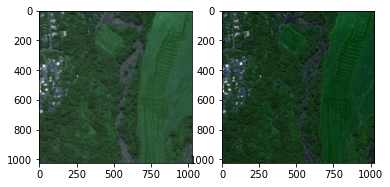

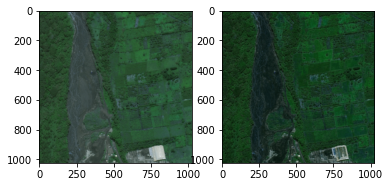

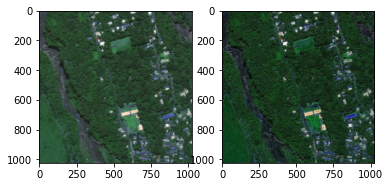

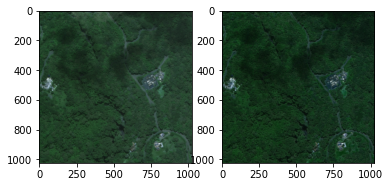

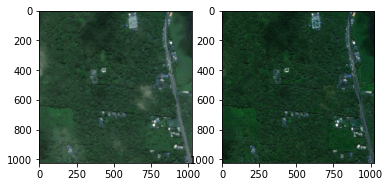

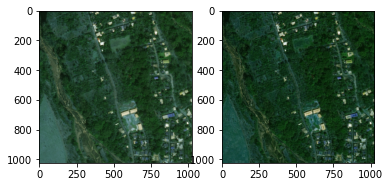

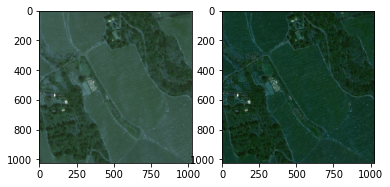

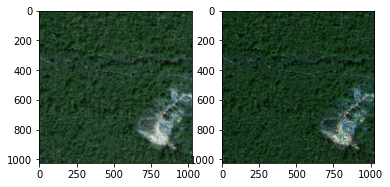

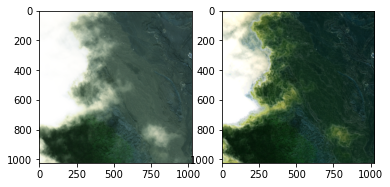

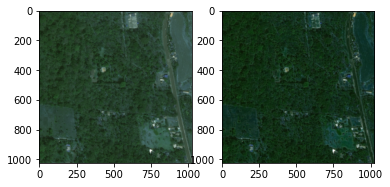

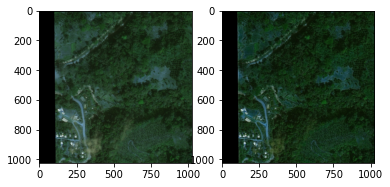

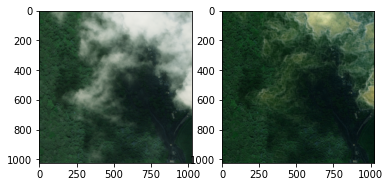

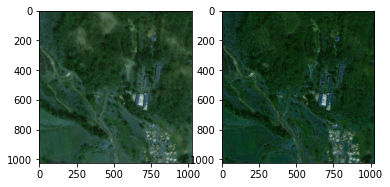

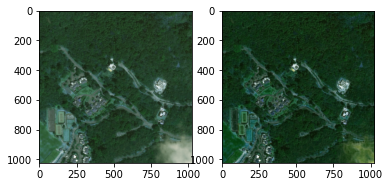

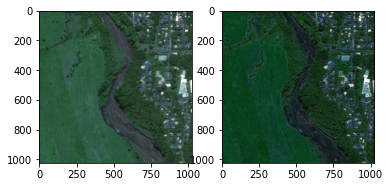

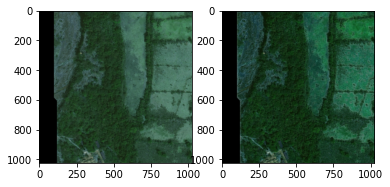

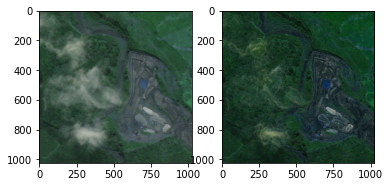

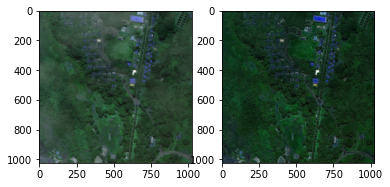

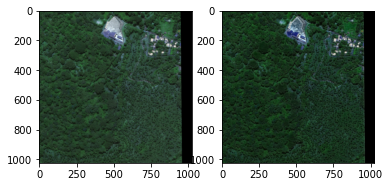

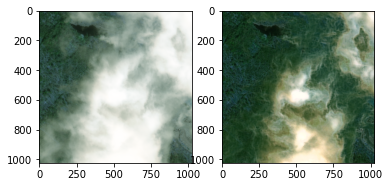

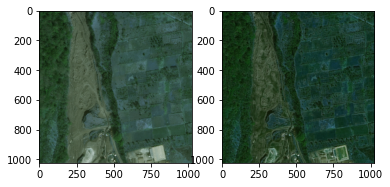

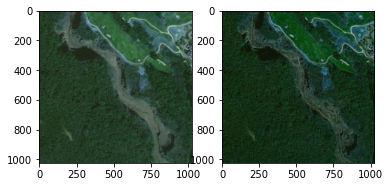

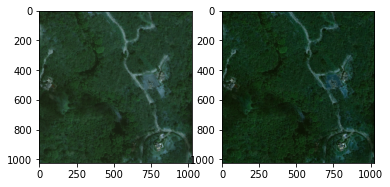

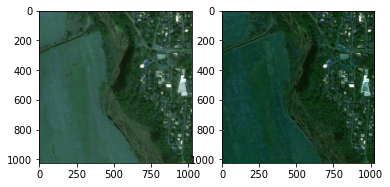

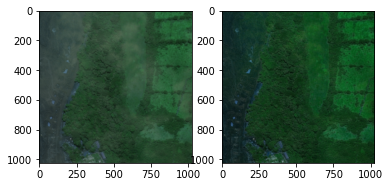

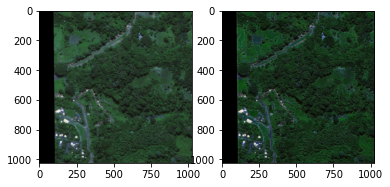

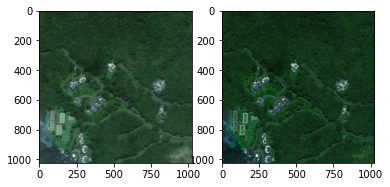

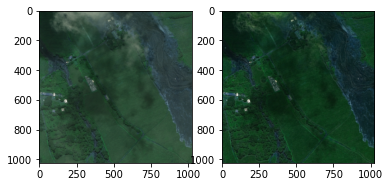

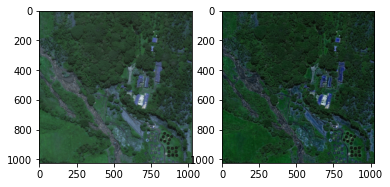

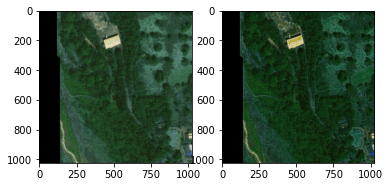

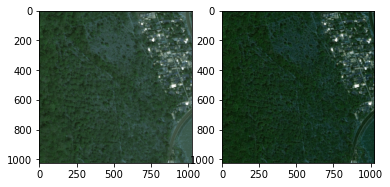

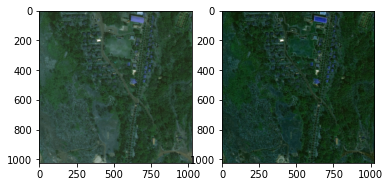

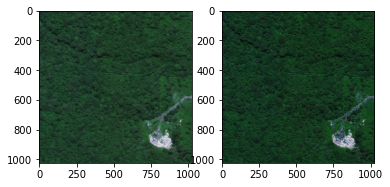

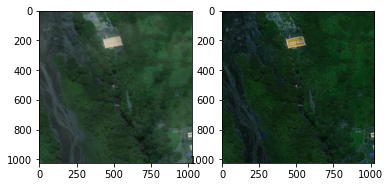

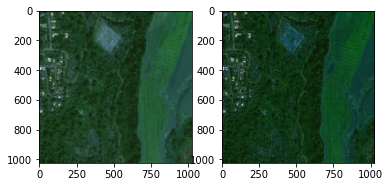

In [32]:
import os
import matplotlib.pyplot as plt

rootDir = '/content/drive/My Drive/subset_images/'
images = os.listdir(rootDir)

for image in images:
  sample(rootDir + image)